# SimCLR
THIS IS A COLAB VERSION OF MY BLOGPOST

https://zablo.net/blog/post/understanding-implementing-simclr-guide-eli5-pytorch/

---
---
---

Transfer learning and pre-training schemas for both NLP and Computer Vision have gained a lot of attention in the last months. Research showed that carefully designed unsupervised/self-supervised training can produce high quality base models and embeddings that greatly decrease the amount of data needed to obtain good classfication models downstream. This approach becomes more and more important as the companies collect a lot of data from which only fraction can be labelled by human - either due to large cost of labelling process or due to some time constraints.

Here I explore SimCLR pre-training framework proposed by Google in <a href="/links/simclr-arxiv-2002.05709/?utm_source=blog&utm_medium=link&utm_campaign=external_links&utm_content=SimCLR-arxiv" target="blank">this arxiv paper</a>. I will explain the SimCLR and its contrastive loss function step by step, starting from naive implementation followed by faster, vectorized one. Then I will show how to use SimCLR's pretraining routine to first build image embeddings using EfficientNet network architecture and finally I will show how to build classifier on top of it.

## TL;DR
This post covers:
* understanding the SimCLR framework
* from scratch explanation & implementation of SimCLR's loss function (NT-Xent) in PyTorch
* pre-training image embeddings using EfficientNet architecture
* training classifier by using transfer learning from the pre-trained embeddings

## Understanding SimCLR framework
In general, SimCLR is <i>a simple framework for contrastive learning of visual representations</i>. It's not any new framework for deep learning, it's a set of fixed steps that one should to follow in order to train image embeddings of good quality.
I drew a schema which explains the flow and the whole representation learning process.

<img src="simclr-schema.png"/>

The flow is as follows (from left to right):
1. Take an input image
2. Prepare 2 random augumentations on the image, including: rotations, hue/saturation/brightness changes, zooming, cropping, etc. The range of augumentations as well as analysis which ones works best are discussed in details in the parper.
1. Run deep neural network (preferably convolutional one, like ResNet50) to obtain image representations (embeddings) for those augumented images.
1. Run small fully connected linear neural network to project embeddings into another vector space.
1. Calculate contrastive loss and run backpropagation throught both networks. Contrastive loss decreases when projections coming from the same image are similar. The similarity between projections can be arbitrary, here I will use cosine similarity, same as in the paper.

## Contrastive loss function
### Theory behind constrastive loss function
One can reason about contrastive loss function form two angles:
1. Contrastive loss decreases when projections of augumented images coming from the same input image are similar.
1. For two augumented images: (i), (j) (coming from the same input image - I will call them "positive" pair later on), the constrative loss for (i) tries to identify (j) among other images ("negative" examples) that are in the same batch .

Formal definition of the loss for pair of positive exmaples (i) and (j) defined as:
<img src="contrastive-loss-lij.png"/>

The final loss is an arithmetic mean of the losses for all positive pairs in the batch:
<img src="contrastive-loss-sum.png"/>
(keep in mind that the indexing in <i>l(2k-1, 2k) + l(2k, 2k-1)</i> is purely dependand on how you implement the loss - I find it easier to understand when I reason about them as <i>l(i,j) + l(j,i)</i>).

### Contrastive loss function - implementation in PyTorch, ELI5 version
It's much easier to implement the loss function without vectorization first and then follow up with the vectorization phase.

In [1]:
!pip install efficientnet_pytorch pytorch-lightning

     |████████████████████████████████| 582 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 102.3 MB/s eta 0:00:01
     |████████████████████████████████| 408 kB 95.2 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 91.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 103.5 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 111.3 MB/s eta 0:00:01
     |████████████████████████████████| 224 kB 109.1 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ed2c78c981a136f52fcc92ed5957cc102f5105e64c262f1d9a007347a3f010b9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-exte

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
class ContrastiveLossELI5(nn.Module):
    def __init__(self, batch_size, temperature=0.5, verbose=True):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.verbose = verbose
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        if self.verbose: print("Similarity matrix\n", similarity_matrix, "\n")
            
        def l_ij(i, j):
            z_i_, z_j_ = representations[i], representations[j]
            sim_i_j = similarity_matrix[i, j]
            if self.verbose: print(f"sim({i}, {j})={sim_i_j}")
                
            numerator = torch.exp(sim_i_j / self.temperature)
            one_for_not_i = torch.ones((2 * self.batch_size, )).to(emb_i.device).scatter_(0, torch.tensor([i]), 0.0)
            if self.verbose: print(f"1{{k!={i}}}",one_for_not_i)
            
            denominator = torch.sum(
                one_for_not_i * torch.exp(similarity_matrix[i, :] / self.temperature)
            )    
            if self.verbose: print("Denominator", denominator)
                
            loss_ij = -torch.log(numerator / denominator)
            if self.verbose: print(f"loss({i},{j})={loss_ij}\n")
                
            return loss_ij.squeeze(0)

        N = self.batch_size
        loss = 0.0
        for k in range(0, N):
            loss += l_ij(k, k + N) + l_ij(k + N, k)
        return 1.0 / (2*N) * loss

#### Explanation
Contrastive loss needs to know the batch size and `temperature` (scaling) parameter. You can find details about setting the optimal `temperature` parameter in the paper.

My implementation of the `forward` of the contrastive loss takes two parameters. First one will be a batch projections of images after first augumentation, the second will be a batch projections of images after second augumentaion.

Projections needs to be normalized first, hence:
```python
z_i = F.normalize(emb_i, dim=1)
z_j = F.normalize(emb_j, dim=1)
```

All representations are concatenated together in order to efficiently calculate cosine similarities between each image pair.

```python
representations = torch.cat([z_i, z_j], dim=0)
similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
```

Next is the naive implementation of <i>l(i,j)</i> for clarity and easiness of understanding. The code bellow almost directly implements the equation:
<img src="contrastive-loss-lij.png"/>
```python
def l_ij(i, j):
    z_i_, z_j_ = representations[i], representations[j]
    sim_i_j = similarity_matrix[i, j]
    numerator = torch.exp(sim_i_j / self.temperature)
    one_for_not_i = torch.ones((2 * self.batch_size, )).to(emb_i.device).scatter_(0, torch.tensor([i]), 0.0)
    denominator = torch.sum(
        one_for_not_i * torch.exp(similarity_matrix[i, :] / self.temperature)
    )

    loss_ij = -torch.log(numerator / denominator)
    return loss_ij.squeeze(0)
```

Then, the final loss for the batch is computed arithmetic mean of all combinations of positive examples:
```python
N = self.batch_size
loss = 0.0
for k in range(0, N):
    loss += l_ij(k, k + N) + l_ij(k + N, k)
return 1.0 / (2*N) * loss
```

Now, let's run it with `verbose` mode to see what's inside.

In [4]:
I = torch.tensor([[1.0, 2.0], [3.0, -2.0], [1.0, 5.0]])
J = torch.tensor([[1.0, 0.75], [2.8, -1.75], [1.0, 4.7]])
loss_eli5 = ContrastiveLossELI5(batch_size=3, temperature=1.0, verbose=True)
loss_eli5(I, J)

Similarity matrix
 tensor([[ 1.0000, -0.1240,  0.9648,  0.8944, -0.0948,  0.9679],
        [-0.1240,  1.0000, -0.3807,  0.3328,  0.9996, -0.3694],
        [ 0.9648, -0.3807,  1.0000,  0.7452, -0.3534,  0.9999],
        [ 0.8944,  0.3328,  0.7452,  1.0000,  0.3604,  0.7533],
        [-0.0948,  0.9996, -0.3534,  0.3604,  1.0000, -0.3419],
        [ 0.9679, -0.3694,  0.9999,  0.7533, -0.3419,  1.0000]]) 

sim(0, 3)=0.8944272398948669
1{k!=0} tensor([0., 1., 1., 1., 1., 1.])
Denominator tensor(9.4954)
loss(0,3)=1.3563847541809082

sim(3, 0)=0.8944272398948669
1{k!=3} tensor([1., 1., 1., 0., 1., 1.])
Denominator tensor(9.5058)
loss(3,0)=1.357473373413086

sim(1, 4)=0.9995677471160889
1{k!=1} tensor([1., 0., 1., 1., 1., 1.])
Denominator tensor(6.3699)
loss(1,4)=0.8520082831382751

sim(4, 1)=0.9995677471160889
1{k!=4} tensor([1., 1., 1., 1., 0., 1.])
Denominator tensor(6.4733)
loss(4,1)=0.8681114912033081

sim(2, 5)=0.9999250769615173
1{k!=2} tensor([1., 1., 0., 1., 1., 1.])
Denominator tenso

tensor(1.1327)

A few things happened there, but by going back and forward between the verbose logs and the equation, everything should become clear.
The indexing jumps by batch size (first `l(0,3), l(3,0)` then `l(1,4), l(4,1)` because the way the similarity matrix was constructed. First row of the `similarity_matrix` is:
```python
[ 1.0000, -0.1240,  0.9648,  0.8944, -0.0948,  0.9679]
```

Remember the input:
```python
I = torch.tensor([[1.0, 2.0], [3.0, -2.0], [1.0, 5.0]])
J = torch.tensor([[1.0, 0.75], [2.8, -1.75], [1.0, 4.7]])
```

Now:

`1.0000` is the cosine similarity between `I[0] and I[0]` (`[1.0, 2.0] and [1.0, 2.0]`)

`-0.1240` is the cosine similarity between `I[0] and I[1]` (`[1.0, 2.0] and [3.0, -2.0]`)

`-0.0948` is the cosine similarity between `I[0] and J[2]` (`[1.0, 2.0] and [2.8, -1.75]`)

... and so on.

Let's see if the loss decreases if the similarity between first image projection increases:

In [5]:
I = torch.tensor([[1.0, 2.0], [3.0, -2.0], [1.0, 5.0]])
J = torch.tensor([[1.0, 0.75], [2.8, -1.75], [1.0, 4.7]])
J = torch.tensor([[1.0, 1.75], [2.8, -1.75], [1.0, 4.7]]) # note the change
ContrastiveLossELI5(3, 1.0, verbose=False)(I, J)

tensor(1.0996)

Indeed the loss decreases! Now I will follow up with the vectorized implementation.

### Contrastive loss function - implementation in PyTorch, vectorized version
Performance of naive implementation is really poor (mostly due to manual loop), see the results:

In [6]:
contrastive_loss_eli5 = ContrastiveLossELI5(3, 1.0, verbose=False)
I = torch.tensor([[1.0, 2.0], [3.0, -2.0], [1.0, 5.0]], requires_grad=True)
J = torch.tensor([[1.0, 0.75], [2.8, -1.75], [1.0, 4.7]], requires_grad=True)

In [7]:
%%timeit
contrastive_loss_eli5(I, J)

646 µs ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Once I understood the internals of the loss, it's easy to vectorize it and remove the manual loop:

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

In [9]:
contrastive_loss = ContrastiveLoss(3, 1.0)
contrastive_loss(I, J).item() - contrastive_loss_eli5(I, J).item()

0.0

The difference should be zero or close to zero (< 1e-6 due to fp arithmetics). Performance comparison:

In [10]:
I = torch.tensor([[1.0, 2.0], [3.0, -2.0], [1.0, 5.0]], requires_grad=True)
J = torch.tensor([[1.0, 0.75], [2.8, -1.75], [1.0, 4.7]], requires_grad=True)

In [11]:
%%timeit
contrastive_loss_eli5(I, J)

668 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit
contrastive_loss(I, J)

193 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Almost 4x improvement, it works.

## Pre-training image embeddings using SimCLR with EfficientNet
Once the loss function is established and understood it's time to make a good use of it. I will pre-train image embeddings using EfficientNet architecture, following the SimCLR framework. For convenenience, I've implemented a few utility functions and classes that I will explain briefly below. The training code is structured using PyTorch-Lightning.

I will use a great EfficientNet [<a href="https://arxiv.org/abs/1905.11946" target="blank">https://arxiv.org/abs/1905.11946</a>] implementation by <a href="https://github.com/lukemelas/EfficientNet-PyTorch.git">Luke Melas-Kyriazi from GitHub</a>, already pre-trained on ImageNet (transfer learning inception!). The dataset I choose is <a href="https://ai.stanford.edu/~acoates/stl10/">STL10</a> (from `torchvision`) as it contains both training and unlabeled splits for unsupervised / self-supervised learning tasks.

> My goal here is to demonstrate the whole SimCLR flow from start to the end. I had no intent to reach new SOTA with the presented configuration.

### Utility functions for image augumentations
Training with SimCLR produces good image embeddings that are not affected by image transformations - this is because during training, various data augumentations are done to force the network to understand the contents of the images regardless of i.e color of the image or the position where the object in the image is placed.
SimCLR's authors say that *composition of data augmentations plays a critical role in defining effective predictive tasks* and also *contrastive learning needs stronger data augmentation than supervised learning*. To sum this up: when pre-training the image embeddings it's good to make this task difficult for the network to learn by strongly augumenting the images in order to generalize better afterwards.

> I strongly advise to read the SimCLR's paper and it's appendix as they did ablation studies on which data augumentations bring the best effects on the embeddings.

To keep this blog-post simple to go through, I will mostly use built-in Torchvision's data augumentations , with one additional one - random resized rotation.

In [13]:
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

In [14]:
class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

In [15]:
class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)
            

In [16]:
from torchvision.datasets import STL10
import torchvision.transforms.functional as tvf
from torchvision import transforms
import numpy as np

A brief look on the transformation results:

In [17]:
stl10_unlabeled = STL10(".", split="unlabeled", download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./stl10_binary.tar.gz to .


In [18]:
idx = 123

In [19]:
random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle), [(0.0, 360.0)])

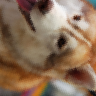

In [20]:
random_resized_rotation(tvf.resize(stl10_unlabeled[idx][0], (96, 96)))

###  Automatic data augumentation wrapper
Here I've also implemented utility dataset wrapper that automatically applies random data augumentations every time when the image is retrieved. It can be easily used with any image dataset as long as it follows the simple interface of returning `tuple` with `(PIL Image, anything)`. This wrapper can be set to return deterministic transformation with `debug` flag set to `True`. Note that there is a `preprocess` step that applies `ImageNet`-originated data standarization as I'm using already pre-trained EfficientNet.

In [21]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
import random

In [22]:
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(96, 96), debug=False):
        super().__init__()
        self.ds = ds
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomResizedCrop(target_size, scale=(1/3, 1.0), ratio=(0.3, 2.0)),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.33),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, _ = self.ds[idx]
        
        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)
        
        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)

        return (t1, t2), torch.tensor(0)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

In [23]:
ds = PretrainingDatasetWrapper(stl10_unlabeled, debug=False)

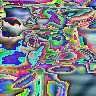

In [24]:
tvf.to_pil_image(ds[idx][0][0])

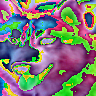

In [25]:
tvf.to_pil_image(ds[idx][0][1])

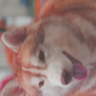

In [26]:
tvf.to_pil_image(ds.raw(idx)[0][1])

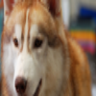

In [27]:
tvf.to_pil_image(ds.raw(idx)[0][0])

### SimCLR neural network for embeddings
Here I define the `ImageEmbedding` neural network which bases on `EfficientNet-b0` architecture. I swap out last layer of pre-trained `EfficientNet` with identity function and add projection for image embeddings on top of it (following the SimCLR paper) with `Linear-ReLU-Linear` layers.

In [28]:
from efficientnet_pytorch import EfficientNet

In [29]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b0")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection


Next is the implementation of PyTorch-Lightning-based training module that orchestrates everything together:
* hyper-parameters handling
* SimCLR ImageEmbedding network
* STL10 dataset
* optimizer
* forward step

As the `PretrainingDatasetWrapper` I've implemented returns tuple of: `(Image1, Image2), dummy class`, the forward step for this module is straightforward - it needs to produce two batches of embeddings and calculate contrastive loss function:
```python
(X, Y), y = batch
embX, projectionX = self.forward(X)
embY, projectionY = self.forward(Y)
loss = self.loss(projectionX, projectionY)
```

In [30]:
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
import pytorch_lightning as pl

In [62]:
class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hyper_params):
        hyper_params = Namespace(**hyper_params) if isinstance(hyper_params, dict) else hyper_params
        super().__init__()
        self.hyper_params = hyper_params
        self.model = ImageEmbedding()
        self.loss = ContrastiveLoss(hyper_params.batch_size)
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hyper_params.epochs
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(stl10_unlabeled, 
                                             debug=getattr(self.hyper_params, "debug", False)),
                          batch_size=self.hyper_params.batch_size, 
                          num_workers=cpu_count(),
                          sampler=SubsetRandomSampler(list(range(hyper_params.train_size))),
                         drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(stl10_unlabeled,
                                            debug=getattr(self.hyper_params, "debug", False)),
                          batch_size=self.hyper_params.batch_size, 
                          shuffle=False,
                          num_workers=cpu_count(),
                          sampler=SequentialSampler(list(range(hyper_params.train_size + 1, hyper_params.train_size + hyper_params.validation_size))),
                         drop_last=True)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        (X, Y), y = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        loss = self.loss(projectionX, projectionY)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hyper_params.lr)
        return [optimizer], []

Initial hyper-parameters. Batch size of 128 works fine with EfficientNet-B0 on GTX1070. Note that I've limitted training dataset to first 10k images from STL10 for convenience of running this blogpost in the form of Jupyter Notebook / Google Colab.

> Important! SimCLR greatly benefits from large batch sizes - it should be set to as high value as possible given the GPU / cluster limits.

In [46]:
from argparse import Namespace
hparams = Namespace(
    lr=1e-3,
    epochs=50,
    batch_size=160,
    train_size=10000,
    validation_size=1000,
    debug=False
)

#### Finding good initial-learning rate using LRFinder algorithm
I use pytorch-lightning's built-in LRFinder algorithm to find initial learning rate.

In [43]:
print(hparams)

Namespace(batch_size=160, epochs=50, lr=0.001, train_size=10000, validation_size=1000)


In [48]:
a = hparams
print(a)

Namespace(batch_size=160, debug=False, epochs=50, lr=0.001, train_size=10000, validation_size=1000)


In [51]:
module = ImageEmbeddingModule(hparams)
t = pl.Trainer(gpus=1)
lr_finder = t.tuner.lr_find(module)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /root/.lr_find_9346ea78-6eb8-4a19-bf73-14c2970d9307.ckpt
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1719: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  "Be aware that when using `ckpt_path`,"


0.0010964781961431851

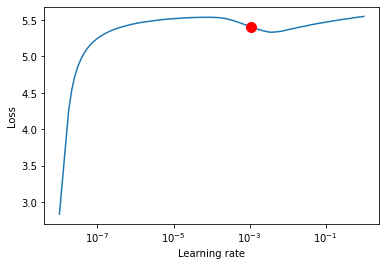

In [52]:
lr_finder.plot(show=False, suggest=True)
lr_finder.suggestion()

I also use W&B Logging to keep track of my experiments:

In [53]:
from pytorch_lightning.loggers import WandbLogger

In [54]:
hparams = Namespace(
    lr=0.0005248074602497723,
    epochs=10,
    batch_size=160,
    train_size=20000,
    validation_size=1000
)
module = ImageEmbeddingModule(hparams)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs)
# Uncomment for W&B integration
# logger = WandbLogger(project="simclr-blogpost")
# logger.watch(module, log="all", log_freq=50)
# trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, logger=logger)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


In [55]:
trainer.fit(module)

Missing logger folder: /root/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | ImageEmbedding  | 6.4 M 
1 | loss  | ContrastiveLoss | 0     
------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.476    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Image classifier on top of SimCLR embeddings
Once the embeddings are trained, they can be used to train classifier on top of them - either by fine tuning the whole network or by freezing the base network with embeddings and learning linear classifier on top of it - I show the latter below.

### Get pure weights of neural network with embeddings
I extract the learned weights for easier usage later on.

In [56]:
checkpoint_file = "efficientnet-b0-stl10-embeddings.ckpt"

In [57]:
trainer.save_checkpoint(checkpoint_file)

In [ ]:
# trainer.logger.experiment.log_artifact(checkpoint_file, type="model")

### Classifier module
Again, I define custom module - this time it uses already existing embeddings and freezes the base model weights on demand.

In [58]:
class SimCLRClassifier(nn.Module):
    def __init__(self, n_classes, freeze_base, embeddings_model_path, hidden_size=512):
        super().__init__()
        
        base_model = ImageEmbeddingModule.load_from_checkpoint(embeddings_model_path).model
        
        self.embeddings = base_model.embedding
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        # Only linear projection on top of the embeddings should be enough
        self.classifier = nn.Linear(in_features=base_model.projection[0].in_features, 
                      out_features=n_classes if n_classes > 2 else 1)

    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)

### Classifier training code
Classifier training code again uses PyTorch lightning, so I'm skipping in-depth explanation.

In [59]:
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR

In [66]:
class SimCLRClassifierModule(pl.LightningModule):
    def __init__(self, hyper_params):
        super().__init__()
        hyper_params = Namespace(**hyper_params) if isinstance(hyper_params, dict) else hyper_params
        self.hyper_params = hyper_params
        self.model = SimCLRClassifier(hyper_params.n_classes, 
                                      hyper_params.freeze_base, 
                                      hyper_params.embeddings_path,
                                      self.hyper_params.hidden_size)
        self.loss = nn.CrossEntropyLoss()
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hyper_params.epochs
    
    def preprocessing(seff):
        return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def get_dataloader(self, split):
        return DataLoader(STL10(".", split=split, transform=self.preprocessing()),
                          batch_size=self.hyper_params.batch_size, 
                          shuffle=split=="train",
                          num_workers=cpu_count(),
                         drop_last=False)
    
    def train_dataloader(self):
        return self.get_dataloader("train")
    
    def val_dataloader(self):
        return self.get_dataloader("test")
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        X, y = batch
        y_out = self.forward(X)
        loss = self.loss(y_out, y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.step(Batch, "test")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hyper_params.lr)
        schedulers = [
            CosineAnnealingLR(optimizer, self.hyper_params.epochs)
        ] if self.hyper_params.epochs > 1 else []
        return [optimizer], schedulers

> It's worth to mention here that training with frozen base model gives a great performance boost during training as the gradients needs to be calculated only for the small portion of the whole network. Additionaly, by utilizing good embeddings, only a few epochs are required to reach good quality classifier with single linear projection.

In [68]:
hparams_cls = Namespace(
    lr=1e-3,
    epochs=5,
    batch_size=160,
    n_classes=10,
    freeze_base=True,
    embeddings_path="./efficientnet-b0-stl10-embeddings.ckpt",
    hidden_size=512
)
module = SimCLRClassifierModule(hparams_cls)
trainer = pl.Trainer(gpus=1, max_epochs=hparams_cls.epochs)
# Uncomment for W&B integration
# logger = WandbLogger(project="simclr-blogpost-classifier")
# logger.watch(module, log="all", log_freq=50)
# trainer = pl.Trainer(gpus=1, max_epochs=hparams_cls.epochs, logger=logger)

TypeError: __init__() missing 1 required positional argument: 'hyper_params'

In [ ]:
lr_find_cls = trainer.lr_find(module)


  | Name  | Type             | Params
-------------------------------------------
0 | model | SimCLRClassifier | 4 M   
1 | loss  | CrossEntropyLoss | 0     


LR finder stopped early due to diverging loss.


0.003981071705534969

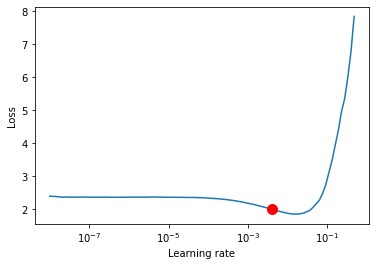

In [ ]:
lr_find_cls.plot(show=False, suggest=True)
lr_find_cls.suggestion()

In [ ]:
hparams_cls = Namespace(
    lr=0.003981071705534969,
    epochs=5,
    batch_size=160,
    n_classes=10,
    freeze_base=True,
    embeddings_path="./efficientnet-b0-stl10-embeddings.ckpt",
    hidden_size=512
)
module = SimCLRClassifierModule(hparams_cls)

Loaded pretrained weights for efficientnet-b0
Freezing embeddings


In [ ]:
trainer.fit(module)


  | Name  | Type             | Params
-------------------------------------------
0 | model | SimCLRClassifier | 4 M   
1 | loss  | CrossEntropyLoss | 0     


1

In [ ]:
from sklearn.metrics import classification_report

### Evaluation
Here I define utility function for evaluating the model using provided data loader:

In [ ]:
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y

In [ ]:
_ = evaluate(module.val_dataloader(), module)

              precision    recall  f1-score   support

           0      0.856     0.864     0.860       800
           1      0.714     0.701     0.707       800
           2      0.903     0.919     0.911       800
           3      0.678     0.599     0.636       800
           4      0.665     0.746     0.703       800
           5      0.633     0.564     0.597       800
           6      0.729     0.781     0.754       800
           7      0.678     0.709     0.693       800
           8      0.868     0.910     0.888       800
           9      0.862     0.801     0.830       800

    accuracy                          0.759      8000
   macro avg      0.759     0.759     0.758      8000
weighted avg      0.759     0.759     0.758      8000



## Summary
I hope you find my explanation of SimCLR framework useful. Feel free to post any comment, fork the notebook and share with ML community!

## Additional links and resources
* SimCLR paper - <a href="https://arxiv.org/pdf/2002.05709.pdf" target="blank">https://arxiv.org/pdf/2002.05709.pdf</a>
* EfficientNet paper - <a href="https://arxiv.org/abs/1905.11946">https://arxiv.org/abs/1905.11946</a>
* this notebook on GitHub - 
* this notebook on Google Colab - 

